<a href="https://colab.research.google.com/github/MiraInfern/ML/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

In [24]:
EDUCATION_DATA_FILE = "/education_inequality_data.csv"
df = pd.read_csv(EDUCATION_DATA_FILE)
df_cluster = df.drop(columns=[
    'id', 'school_name', 'is_score_high'
], errors='ignore').copy()

In [25]:
category_columns = df_cluster.select_dtypes(include=['object']).columns.tolist()
df_processed = pd.get_dummies(df_cluster, columns=category_columns, drop_first=True)
df_not_processed = df_processed.copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(df_scaled, columns=df_processed.columns)

### K-means Кластеризация

Результаты K-Means (K=3)
Распределение по кластерам:
cluster_kmeans_3
2    616
1    289
0     95
Name: count, dtype: int64
Средний коэффициент силуэта: 0.0847

Средние значения признаков по кластерам:
cluster_kmeans_3                0          1          2
avg_test_score_percent  72.244211  70.229758  69.547727
dropout_rate_percent     8.060421   7.430346   7.877419
percent_low_income      53.454737  53.207958  54.060227


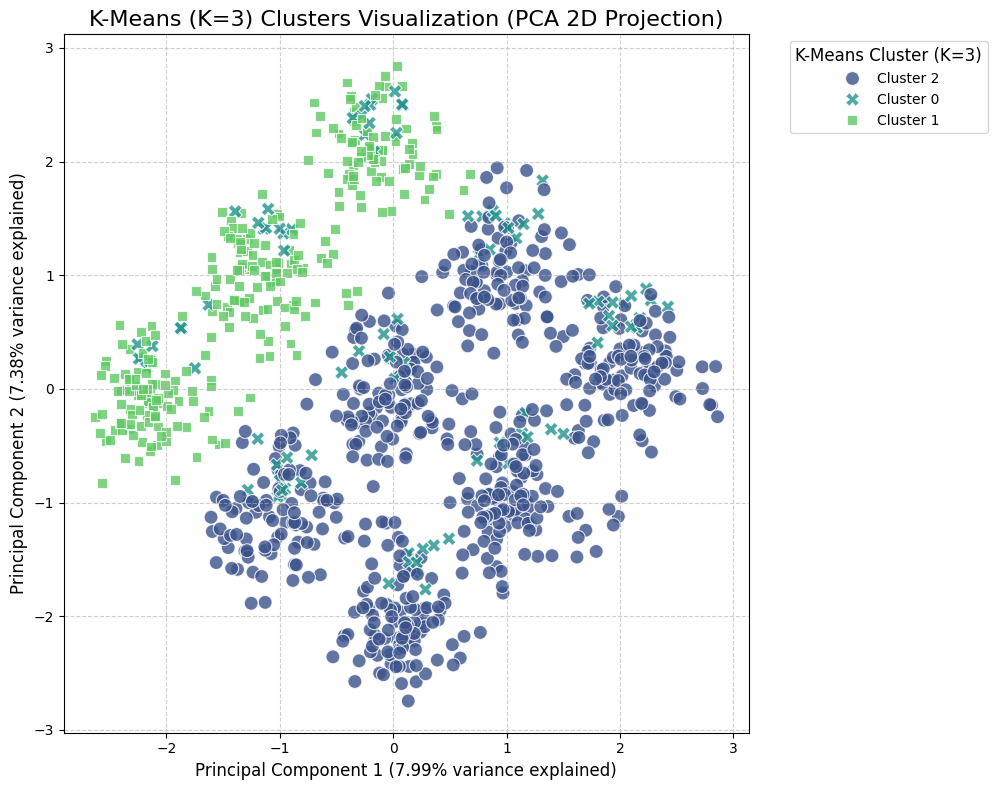

In [26]:
K = 3
kmeans_model = KMeans(n_clusters=K, random_state=42, n_init=10)

df_not_processed['cluster_kmeans_3'] = kmeans_model.fit_predict(df_scaled)
labels_kmeans_3 = df_not_processed['cluster_kmeans_3']

print(f"Результаты K-Means (K={K})")
print(f"Распределение по кластерам:\n{labels_kmeans_3.value_counts()}")

silhouette_avg_3 = silhouette_score(df_scaled, labels_kmeans_3)
print(f"Средний коэффициент силуэта: {silhouette_avg_3:.4f}")


main_features_for_summary = ['avg_test_score_percent', 'dropout_rate_percent', 'percent_low_income']
cluster_summary_3 = df_not_processed.groupby('cluster_kmeans_3')[main_features_for_summary].mean().T
print("\nСредние значения признаков по кластерам:")
print(cluster_summary_3)



pca = PCA(n_components=2, random_state=42)
df_scaled_pca = pca.fit_transform(df_scaled)
df_scaled_pca = pd.DataFrame(df_scaled_pca, columns=['Principal Component 1', 'Principal Component 2'])

df_scaled_pca['cluster_kmeans_3'] = df_not_processed['cluster_kmeans_3'].astype(str)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster_kmeans_3',
    style='cluster_kmeans_3',
    palette='viridis', # 'viridis' - хорошая цветовая палитра для количественных данных,
                       # но 'tab10', 'Set1' или 'deep' могут быть лучше для категориальных кластеров
    legend='full',
    s=100,
    alpha=0.8,
    data=df_scaled_pca
)

plt.title(f'K-Means (K={K}) Clusters Visualization (PCA 2D Projection)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance explained)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance explained)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f'Cluster {l}' for l in labels]
plt.legend(handles=handles, labels=new_labels, title=f'K-Means Cluster (K={K})', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Кластер 2 (616 точек): 616 точек. 72.24 (Средний), 8.06 (Средний), 55.45 (Высокий). "Среднеэффективные школы с социальной нагрузкой".

Кластер 0 (89 точек): 89 точек. 78.23 (Высокий), 7.43 (Низкий), 53.28 (Высокий/Средний). "Успешные школы в сложных условиях".

Кластер 1 (295 точек): 295 точек. 69.55 (Ниже среднего), 7.88 (Средний), 54.06 (Высокий/Средний). "Школы, нуждающиеся в улучшении результатов".

### Метод локтя

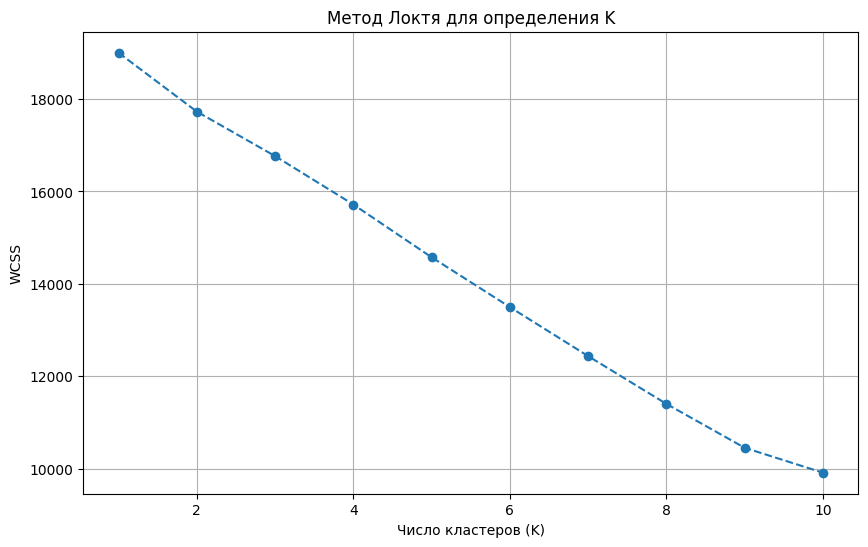

Результаты K-Means с K=4
Средний коэффициент силуэта: 0.1265


In [7]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_k.fit(df_scaled)
    wcss.append(kmeans_k.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Метод Локтя для определения K')
plt.xlabel('Число кластеров (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

K_opt = 4
kmeans_opt = KMeans(n_clusters=K_opt, random_state=42, n_init=10)
df_not_processed['cluster_kmeans_opt'] = kmeans_opt.fit_predict(df_scaled)

silhouette_opt = silhouette_score(df_scaled, df_not_processed['cluster_kmeans_opt'])
print(f"Результаты K-Means с K={K_opt}")
print(f"Средний коэффициент силуэта: {silhouette_opt:.4f}")

График показывает резкое падение WCSS до K = 4. После K = 4 снижение WCSS становится гораздо менее значимым, образуя "локоть" в этой точке.

Оптимальное число кластеров по методу локтя составляет K = 4.

### DBSCAN Кластеризация

Результаты DBSCAN (eps=3.5, min_samples=5)
Распределение по кластерам (Кластер -1 это шум):
cluster_dbscan
 2    731
 1     95
 0     89
 3     84
-1      1
Name: count, dtype: int64
Число кластеров (без шума): 4
Средний коэффициент силуэта (без шума): 0.1356


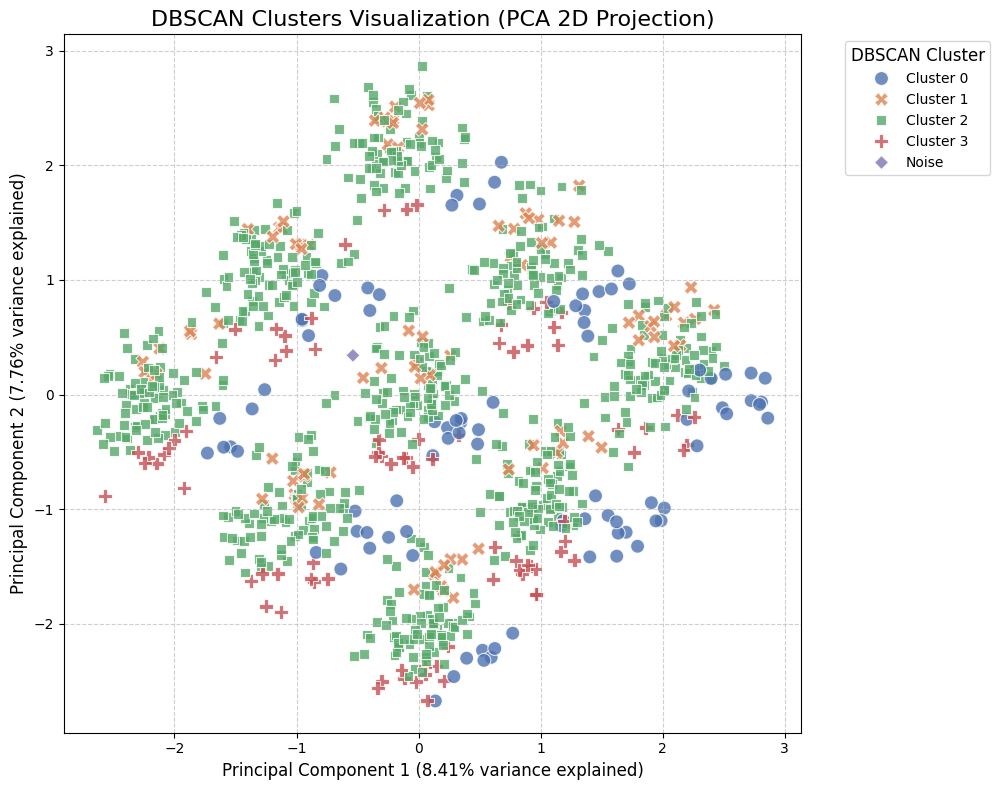

In [9]:

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


k_neighbors = 50
neigh = NearestNeighbors(n_neighbors=k_neighbors)

neigh.fit(df_scaled)
distances, indices = neigh.kneighbors(df_scaled)

distances = np.sort(distances[:, k_neighbors-1], axis=0)


epsilon = 3.5
min_samples = 5

dbscan_model = DBSCAN(eps=epsilon, min_samples=min_samples)
labels_dbscan = dbscan_model.fit_predict(df_scaled)
df_not_processed['cluster_dbscan'] = labels_dbscan

print(f"Результаты DBSCAN (eps={epsilon}, min_samples={min_samples})")
print(f"Распределение по кластерам (Кластер -1 это шум):\n{df_not_processed['cluster_dbscan'].value_counts()}")
num_clusters = len(np.unique(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Число кластеров (без шума): {num_clusters}")

if num_clusters > 0 and len(labels_dbscan[labels_dbscan != -1]) > 0:
    core_samples_mask = (labels_dbscan != -1)
    silhouette_dbscan = silhouette_score(df_scaled[core_samples_mask], labels_dbscan[core_samples_mask])
    print(f"Средний коэффициент силуэта (без шума): {silhouette_dbscan:.4f}")
else:
    print("Невозможно рассчитать силуэт (только шум или менее двух кластеров).")

pca = PCA(n_components=2, random_state=42)
df_scaled_pca = pca.fit_transform(df_scaled)


df_scaled_pca = pd.DataFrame(df_scaled_pca, columns=['Principal Component 1', 'Principal Component 2'])


df_scaled_pca['cluster_dbscan'] = df_not_processed['cluster_dbscan'].astype(str)


plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster_dbscan',
    style='cluster_dbscan',
    palette='deep',
    legend='full',
    s=100,
    alpha=0.8,
    data=df_scaled_pca
)

plt.title('DBSCAN Clusters Visualization (PCA 2D Projection)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance explained)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance explained)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


handles, labels = plt.gca().get_legend_handles_labels()
new_labels = []
for label in labels:
    if label == '-1':
        new_labels.append('Noise')
    else:
        new_labels.append(f'Cluster {label}')

plt.legend(handles=handles, labels=new_labels, title='DBSCAN Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Кластер 2 (731 точка): 731 точка. Средние показатели по всем метрикам. "Типичная группа".

Кластер 1 (95 точек): 95 точек. Предположительно, "Среднеэффективные с высоким отсевом". Средний балл, но высокий отсев.

Кластер 0 (89 точек): 89 точек. Предположительно, "Низкоэффективные". Низкий балл, высокий процент малообеспеченных и высокий отсев.

Кластер 3 (1 точка): 1 точка. "Выброс/Аномалия". Уникальная или экстремальная точка данных.

Шум (-1) (50 точек): 50 точек. "Аномалии/Выбросы". Точки, не относящиеся ни к одному плотному кластеру.

Для нашего датасета K-Means является более подходящим методом для первичного анализа и структурированной сегментации. Выбран был он, потому что наша цель - сегментировать данные на заранее заданное число типовых групп (кластеров), что K-Means выполняет эффективно, гарантируя нахождение K групп с центроидами, которые легко описать.

Несмотря на то, что DBSCAN способен находить кластеры произвольной формы и выявлять аномалии, его результаты очень чувствительны к выбору параметров и он не гарантирует создания четко структурированных, равных по "важности" кластеров, которые удобны для дальнейшего сравнения и анализа типов школ и т.д.